In [44]:
# utils
import pandas as pd
import numpy as np


#plot
import matplotlib.pyplot as plt
import seaborn as sns

# Learning
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV


In [2]:
# IMPORT DATA

#import shower summary tables
fn_ph = pd.read_csv("../shower_data/350shower/final_ph.csv",index_col=0)
fn_pr = pd.read_csv("../shower_data/350shower/final_pr.csv",index_col=0)

In [3]:
# DATA TABLE CREATION

#join them
#all_ph = fn_ph.append(fn_pr)
#all_ph.reset_index(drop=True, inplace=True)

all_ph = pd.read_csv("../shower_data/combined_all_1600.csv")

# log10 to dt, E, and counts
#all_ph[["dt"]]=all_ph["dt"].apply(np.log10) # nano sec
#all_ph[["dxy"]]=all_ph["dxy"].apply(np.log10) # m2
#all_ph[["E"]]=all_ph["E"].apply(np.log10) # GeV
#all_ph[["muon_detector_array"]]=all_ph["muon_detector_array"].apply(lambda x : np.log10(x+1))
#all_ph[["em_scintillator_array"]]=all_ph["em_scintillator_array"].apply(lambda x : np.log10(x+1))
all_ph.head(5)

,dt,dxy,em_scintillator_array,muon_detector_array,origin
0,1.591065,3.736556,2.891537,0.477121,1
1,1.612784,3.971415,2.670246,0.301030,1
2,1.579784,3.890365,2.818226,0.000000,1
3,1.414973,3.749195,2.684845,0.301030,1
4,1.462398,3.839855,2.964260,0.602060,1


## Data exploration

Plot the data tables and observe patters among the feature space tu determine the best ML approach.


**NOTE:** "Energy" feature might not be measurable as in this table, which include the simulated Energy value for each particle. this information is lost and replaced by the energy threshold of the detector so it might not be provided in the future. This is a mere excercise to check the correlation between energy and type of primary particle.

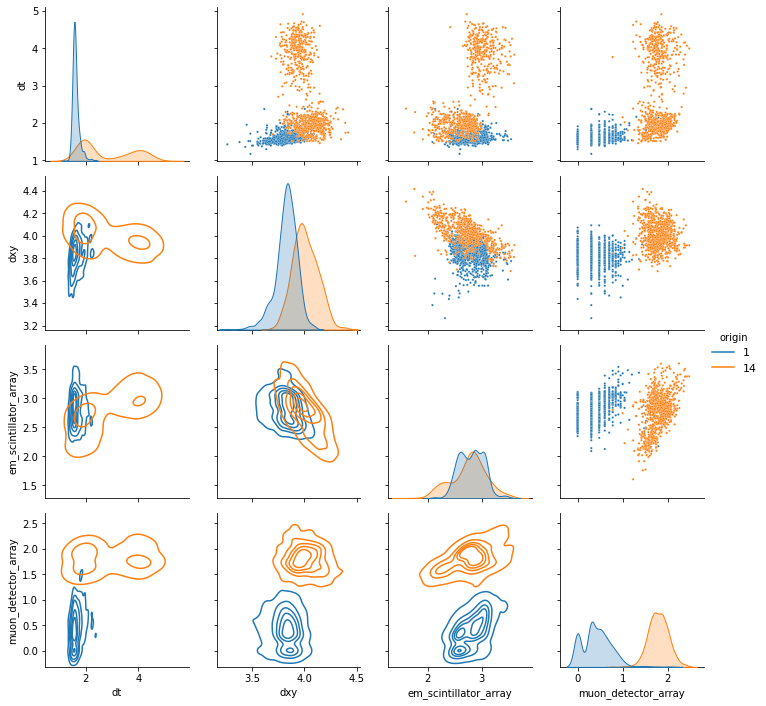

In [51]:
g = sns.PairGrid(all_ph,hue="origin",palette="tab10")
g.map_upper(sns.scatterplot,s=5)
g.map_lower(sns.kdeplot,levels=6,thresh=.05)
g.map_diag(sns.kdeplot,fill=True)
g = g.add_legend(fontsize=11)

Now, lets check the correlation and covariance between the features and the target "origin".

<AxesSubplot:title={'center':'Covariance Matrix'}>

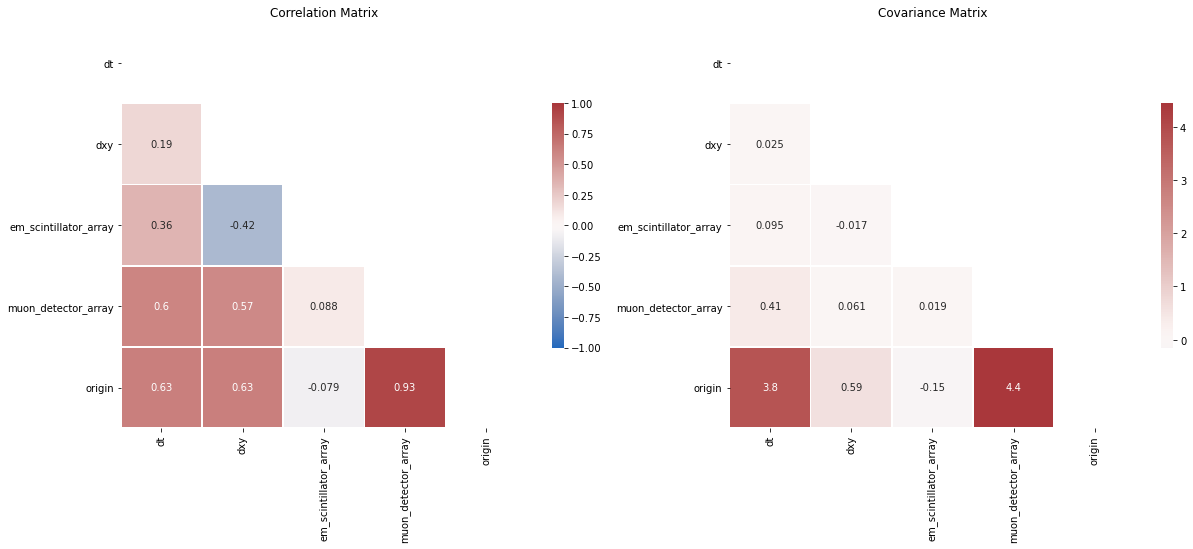

In [5]:
data_ = all_ph[["dt","dxy","em_scintillator_array","muon_detector_array","origin"]]

corr = data_.corr()
covv = data_.cov()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))


plt.subplot(1,2,1)
plt.title("Correlation Matrix")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=sns.color_palette("vlag", as_cmap=True), vmax=1, vmin=-1,center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.subplot(1,2,2)
plt.title("Covariance Matrix")



# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(covv, mask=mask, cmap=sns.color_palette("vlag", as_cmap=True), center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [66]:
corr["origin"].abs().mean() 
# a measure of total correlation for the table with the target

0.6530107758988064

## using Support Vector classifier
Let's train a SVC in order to predict the region of each domain. A SVC is useful for setting multidimensional boundaries since the SVC works by principle by maximizing the distance between the datapoints and the boundary itself . For this first approach, let's use only the counts for each shower on each type of detector. 

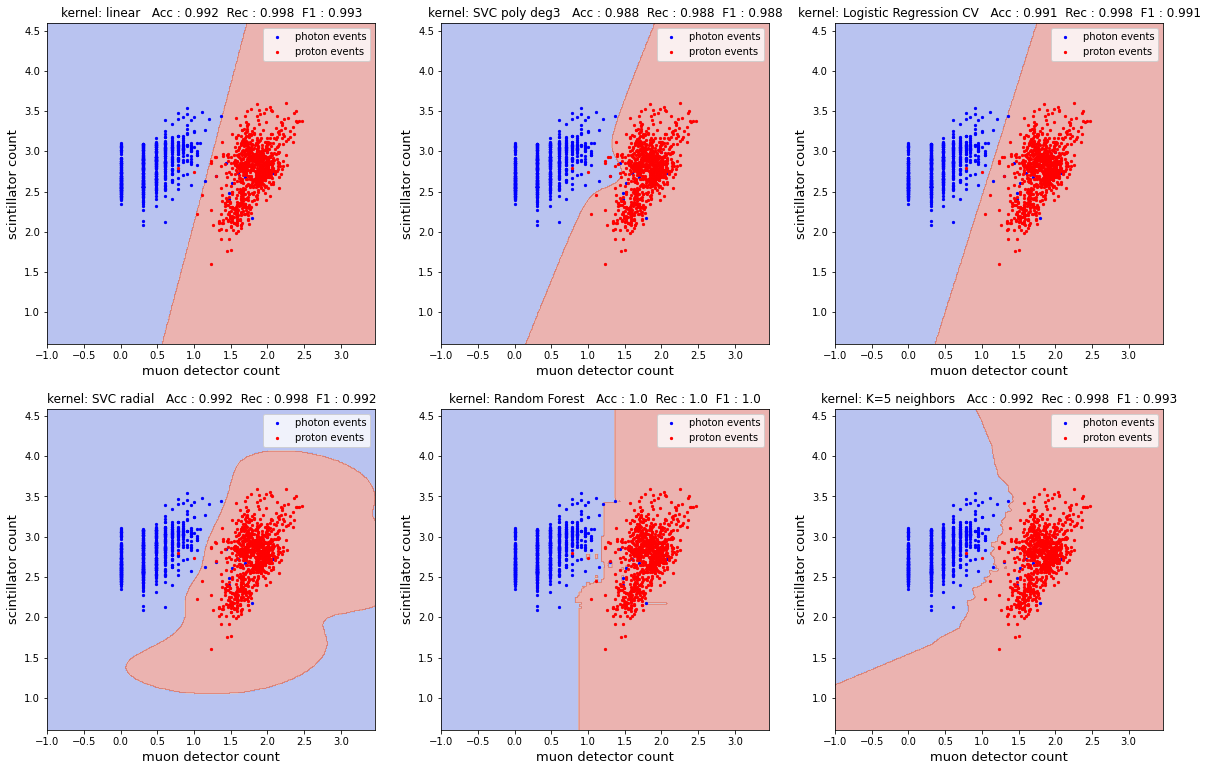

In [72]:

x = all_ph[["muon_detector_array","em_scintillator_array"]].values
y = np.array([0 if d ==1 else 1 for d in all_ph["origin"].values])

h = 0.01  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors

# create a mesh to plot in
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

    


C = 5  #egularization parameter
models = [svm.SVC(kernel="linear",C=C),
         svm.SVC(kernel="poly",degree=3,C=C),
         LogisticRegressionCV(cv=10),
         svm.SVC(kernel="rbf",C=C),
         RandomForestClassifier(n_estimators=50),
          KNeighborsClassifier(n_neighbors=5)
         ]

names = ["linear","SVC poly deg3","Logistic Regression CV","SVC radial","Random Forest","K=5 neighbors"]

plt.figure(figsize=(20,13))

for i in range(len(models)):
    
    plt.subplot(2,3,i+1)
    
    # standar scaler substract the mean from the data and then divides by the standard deviation
    # since it is used with a pipeline, it will scale every input before feeding it into the model
    # this scaler is fitted in the data so it will only reduce this data 
    clf = make_pipeline(StandardScaler(),models[i]) 
    
    clf.fit(x,y)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    
    #plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.contourf(xx,yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)

    plt.scatter(x[y==0][:,0],x[y==0][:,1], c="b",label="photon events",s=5)
    plt.scatter(x[y==1][:,0],x[y==1][:,1], c="r",label="proton events",s=5)

    plt.xlabel("muon detector count",fontsize=13)
    plt.ylabel("scintillator count",fontsize=13)
    
    
    y_pred = clf.predict(x)
    acc_i = round(accuracy_score(y,y_pred),3)
    rec_i = round(recall_score(y,y_pred),3)
    f1_i = round(f1_score(y,y_pred),3)
    plt.title("kernel: {}   Acc : {}  Rec : {}  F1 : {}".format(names[i],acc_i,rec_i,f1_i))
    plt.legend()




Accuracy measures "of all the classifications, how many of them were done correctly?" while recall measures "of all proton showers, how many of them were correctly classified?". In each plot the values specified in the title correspond to the test sample evaluation (over the whole samlple of datapoints). the model is trained and evaluated over all the samples, this is just to generate the region boundary with as much data as posible.

### PCA exploration

With a linear transformation over the hyperspace of features, we can change project the features over the **n** orthongonal components (or dimensions) that better express the variance of the data. A 2-component PCA is used to change the basis of the data to one that projects the features in the plane with higher variance.

In [7]:
#all feautres
X =  all_ph[["muon_detector_array","em_scintillator_array","dt","dxy"]].values
#target
y = np.array([0 if d ==1 else 1 for d in all_ph["origin"].values])#.reshape(-1,1)

pca = PCA(n_components=2) # PCA

pca.fit(X) # fit the PCA using the features
x_pca = pca.transform(X) #project the features over the 2 principal components using PCA 

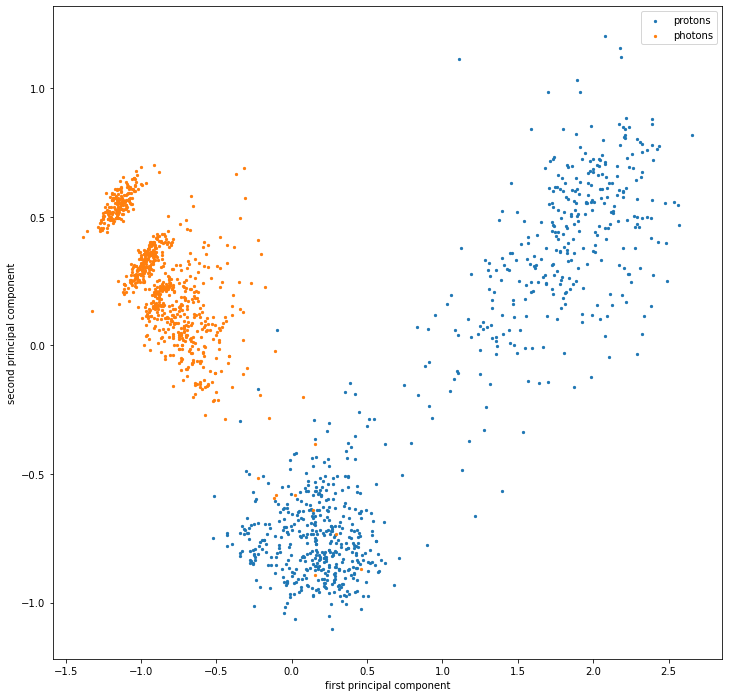

In [8]:
plt.figure(figsize=(12,12))
plt.scatter(x_pca[:,0][y==1],x_pca[:,1][y==1],label="protons",s=5)
plt.scatter(x_pca[:,0][y==0],x_pca[:,1][y==0],label="photons",s=5)
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.legend()

In [9]:
print(pca.components_) # A transformation matrix from a 4D space to a 2D space. bias due to data average not included
# this is the component matrix

[[ 0.55605106  0.08132252  0.82585482  0.04645097]
 [-0.80878708  0.19480238  0.53388518 -0.1512683 ]]


In [10]:
print(pca.mean_) #mean value of each component. aditive constant . mean value vector

[1.10608902 2.7821014  2.19926232 3.91658512]


Doing a classification in this space seems relatively straight-forward, and since the Linear kernel is simple and well-behaved it is used to classify the events in this space of reduced dimensionality.

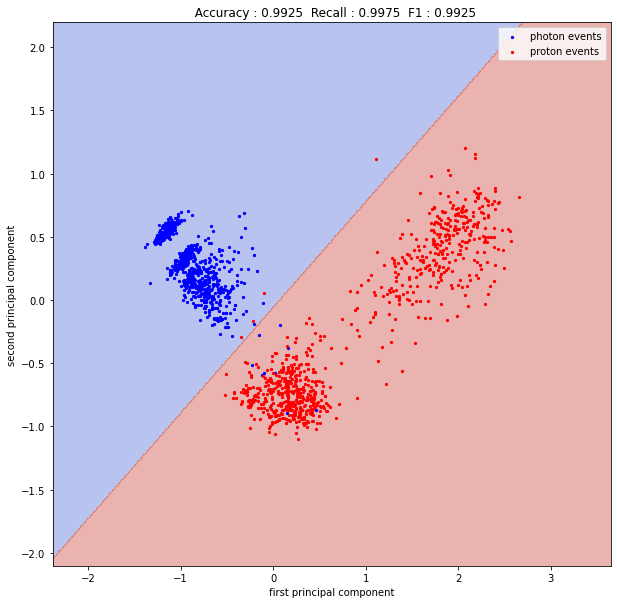

In [74]:
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = x_pca[:, 0].min() - 1, x_pca[:, 0].max() + 1
y_min, y_max = x_pca[:, 1].min() - 1, x_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#train-test sample splitting
x_train,x_test,y_train,y_test = train_test_split(x_pca,y,test_size=0.3)


#building the classifier
clf = svm.SVC(kernel="linear")  # RandomForestClassifier(n_estimators=20,oob_score=True))
clf.fit(x_train, y_train)


#region classification
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.contourf(xx,yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)

plt.scatter(x_pca[y==0][:,0],x_pca[y==0][:,1], c="b",label="photon events",s=5)
plt.scatter(x_pca[y==1][:,0],x_pca[y==1][:,1], c="r",label="proton events",s=5)

plt.xlabel("first principal component")
plt.ylabel("second principal component")
acc_i = round(accuracy_score(y,y_pred),4)
rec_i = round(recall_score(y,y_pred),4)
f1_i = round(f1_score(y,y_pred),4)
plt.title("  Accuracy : {}  Recall : {}  F1 : {}".format(acc_i,rec_i,f1_i))

plt.legend()

Any new set of features X in the 4D space can be classified using this trained models following the steps:
* **Transform** X using the PCA tranformation. This can be done using the method `PCA.transform` with the trained PCA model or with the operation   $$(X-\tilde{x})\cdot V = \hat{X}$$ where V is the component matrix and $\tilde{x}$ is the mean values vector.

* **Predict** the target values with the pre-trained SVC lineal model using `clf.predict(...)`. since SVC is a classifier it will output 0 or 1, corresponding to gamma or proton induced particle shower. 


**NOTE** the convention used is positive events (1) correspond to proton-induced showers (PS), the events that neet to be excluded. Negative events (0) are the gamma-induced showers (GS).

**NOTE** since the goal is to always classify PS correctly, even if it that means to classify some GS wrong (up to certain tolerance), we want to maximize the **RECALL**. The recall in is the proportion of PS classified correctly over the total number of PS, so this number must be close or equal to 1. 

**NOTE** the tolerance in the GS misclassification declares the maximum amount (proportion) of GS that can be classified wrong with the aim of detecting better the PS. This means that we want to mantain the **SPECIFICTY** above certain threshold while minimizing the recall. The specificity is the proportion of GS classified correctly over the total number of PS.

**NOTE** the [LHAASO paper](https://www.nature.com/articles/s41586-021-03498-z) reports "*KM2A is capable of rejecting the CR background by a factor of* $10^{−2}$*at 20 TeV and* $10^{−4}$ *above 100 TeV*".

Meaning that $1 -$ recall $ \sim 10^{−4}$ 

In [12]:
#datax = pd.read_csv("../energy_exploration/combined_energy_eploration.csv")
#datax = all_ph[["dt","dxy","em_scintillator_array","muon_detector_array","origin"]].append(datax)
#datax.reset_index()
#datax.to_csv("combined_all_1600.csv",index=False)

In [49]:
all_ph.sample(5)

,dt,dxy,em_scintillator_array,muon_detector_array,origin
793,1.612784,3.865222,2.562293,0.000000,1
1281,1.845098,4.197804,2.262451,1.579784,14
800,1.505150,3.909823,2.582063,0.000000,1
215,1.724276,3.934852,2.556303,0.301030,1
1213,1.518514,4.023664,2.276462,1.414973,14
